<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>DECam HiTS Analysis Notebook</b> <br>
Contact author: Erin Howard<br>
Last verified to run: March 1, 2023<br>
LSST Science Piplines version: w_2023_07<br>
Container Size: Large <br>

# DM-37698: ApPipe on DECam HiTS with Preconvolution, February 2023

DECam HiTS with preconvolution, compared with February 2023 base run.

* Uses `decam_rings_v1` skymap
* Templates from HiTS 2014 are in `/sdf/group/rubin/repo/main/u/elhoward/DM-36024/templates`
* Final processing of HiTS 2015 is in `u/elhoward/DM-37698/HiTS-precon`
* Postgres schema is `elhoward_dm37698_hits_appipe`
* Working directory on USDF with bps logs, pipelines, etc. is `/sdf/group/rubin/u/elhoward/repo-main-logs/DM-37698`

For ApPipe.yaml:
```
inCollection: DECam/defaults/hits2015,u/mrawls/DM-34710-hits-crosstalk-sources,u/mrawls/DM-34710/templates
dataQuery: "instrument='DECam' AND skymap='decam_rings_v1' AND detector NOT IN (2, 61) AND exposure>400000"
```

Notes: The exposure cuts are necessary to force each pipeline to use only the 2014 images (numbered in the 200000s) for template building, and to use only the 2015 images (numbered in the 400000s) as science images.

## Previous Runs 

## Table of Contents

1. [Loading DiaObjects and DiaSources](#section_1)
2. [DiaObject and DiaSources analysis](#section_2)
3. [Comparisons to previous processing run](#section_3)
4. [SNR distributions](#section_4)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import importlib
import pandas as pd
import astropy.units as u
import lsst.afw.display as afwDisplay

import lsst.daf.butler as dafButler
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

<module 'lsst.analysis.ap.legacyApdbUtils' from '/sdf/data/rubin/u/elhoward/repos/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py'>

## 1. <a id="section_1">Loading DiaObjects and DiaSources</a>

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'DECam'
skymap = 'decam_rings_v1'

dbType='postgres'
dbName='lsst-devl'

fakeStatus = 'no fakes'

dmnum = '37698'
collections = f'u/elhoward/DM-{dmnum}/HiTS-precon'
schema = f'elhoward_dm{dmnum}_hits_appipe'
month = 'February (Precon)'
year = '2023'

dmnum_old = '37694'
collections_old = f'u/elhoward/DM-{dmnum_old}/hits2015'
schema_old = f'elhoward_dm{dmnum_old}_hits_appipe'
month_old = 'February (Base)'
year_old = '2023'

collectionsList = [collections,collections_old]

In [3]:
objTable, srcTable, goodObj, goodSrc = utils.loadTables(repo,
                                                      dbName=dbName,
                                                      dbType=dbType,
                                                      instrument=instrument,
                                                      schema=schema)

In [4]:
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = utils.makeSrcTableFlags(srcTable, objTable,
                                                                               instrument=instrument,
                                                                               repo=repo)

In [5]:
objTable_old, srcTable_old, goodObj_old, goodSrc_old = utils.loadTables(repo,
                                                      dbName=dbName,
                                                      dbType=dbType,
                                                      instrument=instrument,
                                                      schema=schema_old)

In [6]:
flagTable_old, srcTableFlags_old, flagFilter_old, goodSrc_old, goodObj_old = utils.makeSrcTableFlags(srcTable_old, objTable_old,
                                                                               instrument=instrument,
                                                                               repo=repo)

## 2. <a id="section_2">DIA object and source visual analysis</a>

In [7]:
bandList = ['g']
colorList = ['C2']
collection = collections

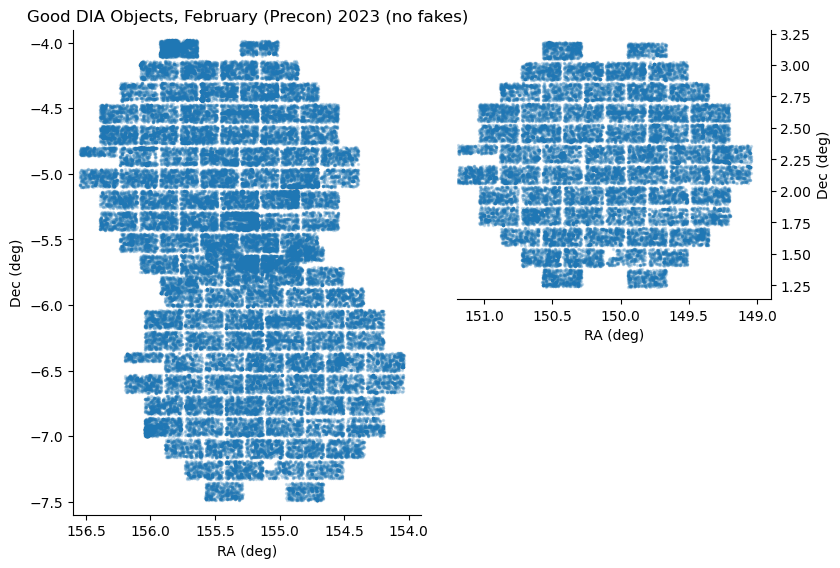

In [8]:
hitsPlot = plac.plotHitsSourcesOnSky(goodObj, title=f'Good DIA Objects, {month} {year} ({fakeStatus})')

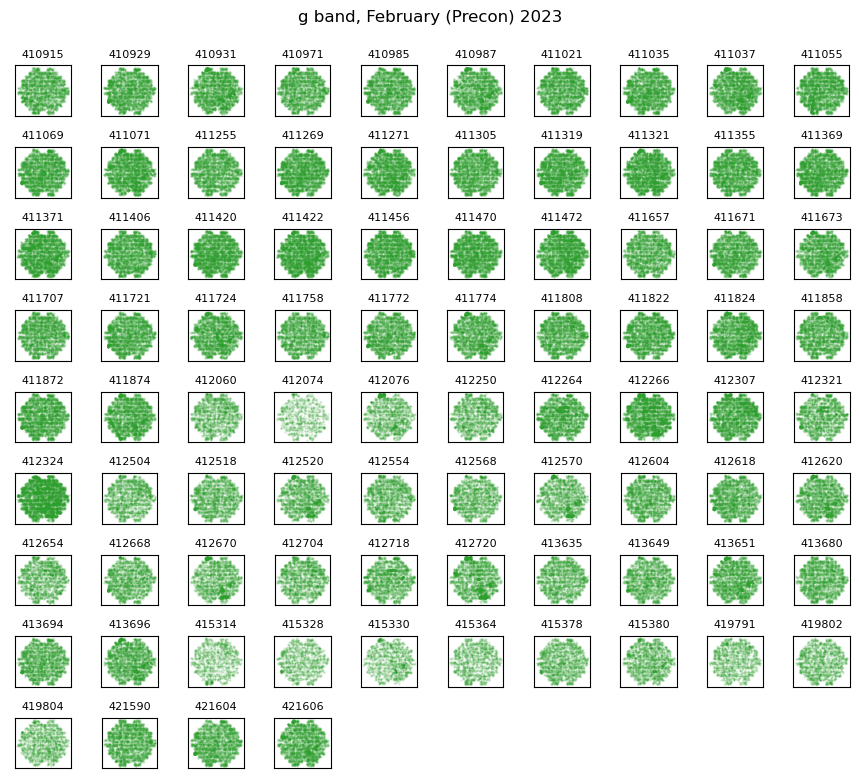

In [9]:
for band, color in zip(bandList, colorList):
    plac.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band], title=band+f' band, {month} {year}', color=color, size=1)

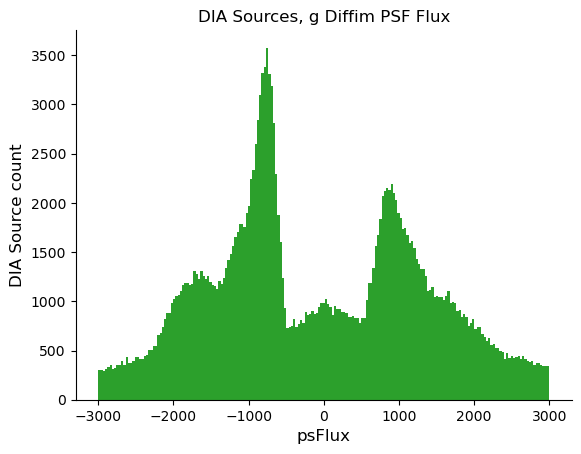

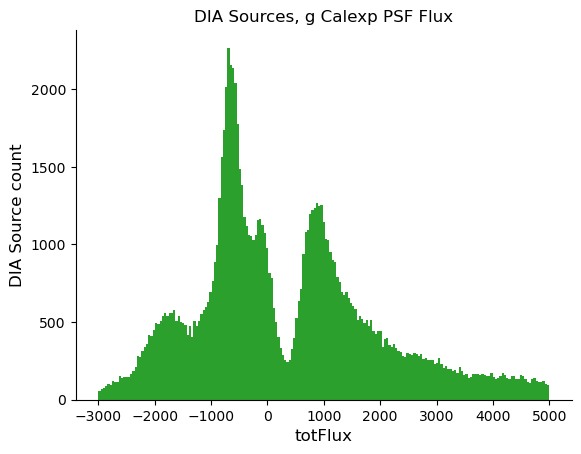

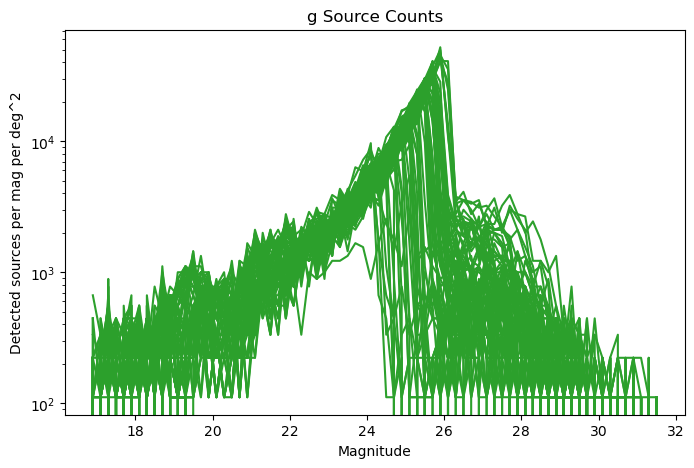

In [10]:
for band, color in zip(bandList, colorList):
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                        title=f'DIA Sources, {band} Diffim PSF Flux', color1=color, binmin=-3e3, binmax=3e3)
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                        title=f'DIA Sources, {band} Calexp PSF Flux', color1=color, binmin=-3e3, binmax=5e3)
    plac.source_magnitude_histogram(repo, goodSrc, band, 'DECam', collection)

## 3. <a id="section_3">Comparison to previous processing run</a>

Large increase in DIA objects and sources, moderate increase in good DIA objects and slight increase in good DIA sources. The shape of the psFlux and totFlux histograms changed, most noteably around zero and in the negatives. Noticeable increase in edge and suspect flags.

Text(0.5, 1.0, 'Comparing DIA Object and Source counts (no fakes)')

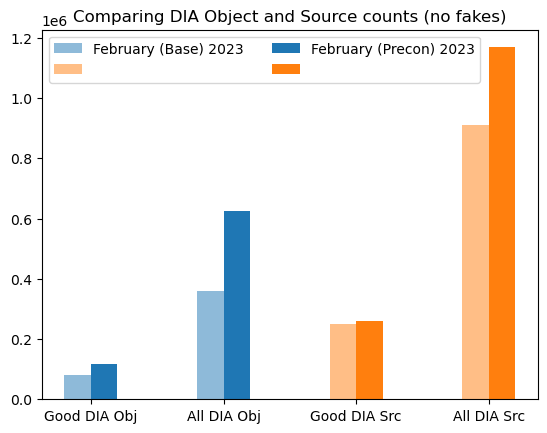

In [11]:
label1 = f'{month_old} {year_old}'
label2 = f'{month} {year}'

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.2

# Previous Run
ax.bar(xbar - width/2, [len(goodObj_old), len(objTable_old)], 
       width, label=label1, color='C0', alpha=0.5)
ax.bar(xbar + 2 - width/2, [len(goodSrc_old), len(srcTable_old)],
       width, label=' ', color='C1', alpha=0.5)

# Current Run
ax.bar(xbar + width/2, [len(goodObj), len(objTable)], 
       width, label=label2, color='C0')
ax.bar(xbar + 2 + width/2, [len(goodSrc), len(srcTable)],
       width, label=' ', color='C1')

plt.legend(ncol=2)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title(f'Comparing DIA Object and Source counts ({fakeStatus})')

In [12]:
nObj = len(objTable)
nObj_old = len(objTable_old)

print(f"{month} {year}, Number of objects: ",nObj)
print(f"{month_old} {year_old}, Number of objects: ",nObj_old)

print("Diff: ", nObj-nObj_old)

February (Precon) 2023, Number of objects:  625077
February (Base) 2023, Number of objects:  358102
Diff:  266975


In [13]:
nGoodObj = len(goodObj)
nGoodObj_old = len(goodObj_old)

print(f"{month} {year}, Number of good objects: ",nGoodObj)
print(f"{month_old} {year_old}, Number of good objects: ",nGoodObj_old)

print("Diff: ", nGoodObj-nGoodObj_old)

February (Precon) 2023, Number of good objects:  116754
February (Base) 2023, Number of good objects:  79749
Diff:  37005


In [14]:
nGoodSrc = len(goodSrc)
nGoodSrc_old = len(goodSrc_old)

print(f"{month} {year}, Number of good sources: ",nGoodSrc)
print(f"{month_old} {year_old}, Number of good sources: ",nGoodSrc_old)

print("Diff: ", nGoodSrc-nGoodSrc_old)

February (Precon) 2023, Number of good sources:  259457
February (Base) 2023, Number of good sources:  251170
Diff:  8287


In [15]:
nSrc = len(srcTable)
nSrc_old = len(srcTable_old)

print(f"{month} {year}, Number of sources: ",nSrc)
print(f"{month_old} {year_old}, Number of sources: ",nSrc_old)

print("Diff: ", nSrc-nSrc_old)

February (Precon) 2023, Number of sources:  1168590
February (Base) 2023, Number of sources:  911051
Diff:  257539


Text(0.5, 0.98, 'Good DIA Objects (no fakes)')

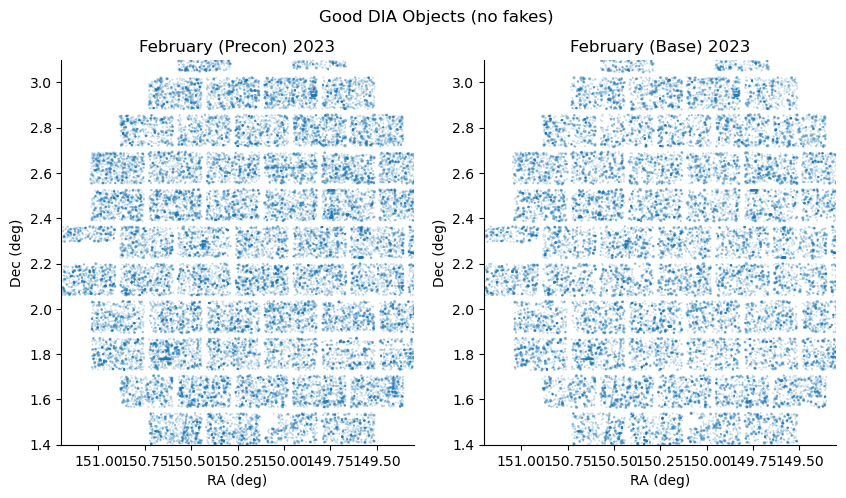

In [16]:
fig = plt.figure(figsize=(10,5))

cutoff = 0  # only plot DIA Objects composed of cutoff or more DIA Sources

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], 
           goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/3, 
           marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'{month} {year}')

ax2 = fig.add_subplot(122)
plt.setp(ax2, xlim=xlim, ylim=ylim)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'ra'], 
            goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'decl'], 
            c='C0', s=goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'nDiaSources']/3, 
            marker='.', alpha=0.4)
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.set_title(f'{month_old} {year_old}')

plt.suptitle(f'Good DIA Objects ({fakeStatus})')

Text(0.5, 0.98, 'DIA Objects composed of > 3 "Good" DIA Sources (no fakes)')

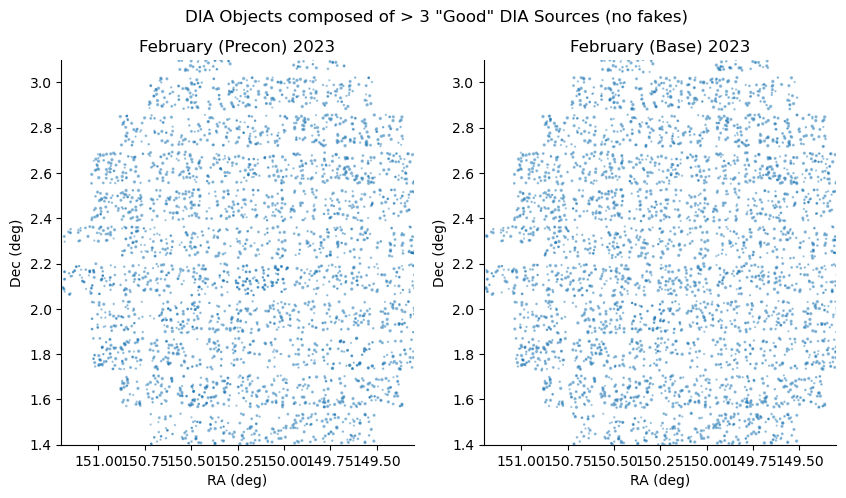

In [17]:
fig = plt.figure(figsize=(10,5))

cutoff = 3  # only plot DIA Objects composed of cutoff or more DIA Sources

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], 
           goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/3, 
           marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'{month} {year}')

ax2 = fig.add_subplot(122)
plt.setp(ax2, xlim=xlim, ylim=ylim)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'ra'], 
            goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'decl'], 
            c='C0', s=goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'nDiaSources']/3, 
            marker='.', alpha=0.4)
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.set_title(f'{month_old} {year_old}')

plt.suptitle(f'DIA Objects composed of > {cutoff} "Good" DIA Sources ({fakeStatus})')

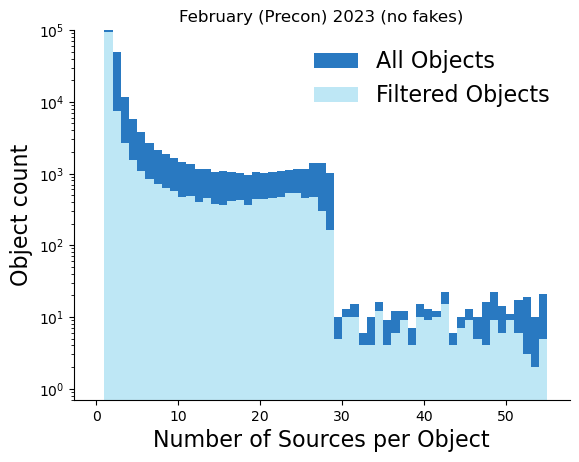

In [18]:
hist = plac.plotDiaObjectHistogram(objTable, goodObj, title=f'{month} {year} ({fakeStatus})')

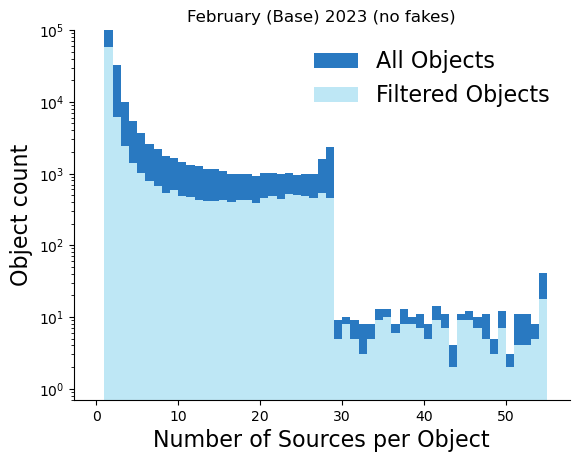

In [19]:
hist = plac.plotDiaObjectHistogram(objTable_old, goodObj_old, title=f'{month_old} {year_old} ({fakeStatus})')

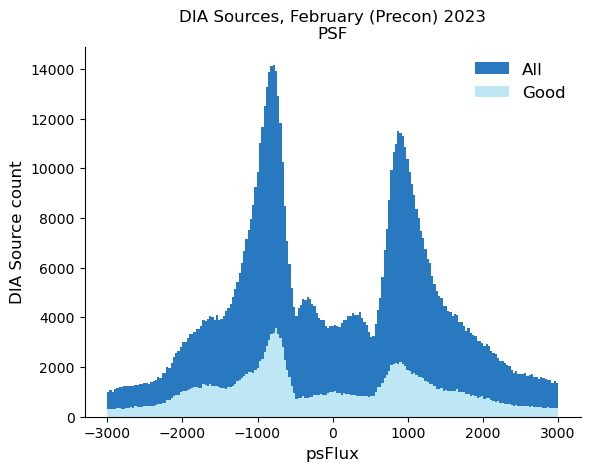

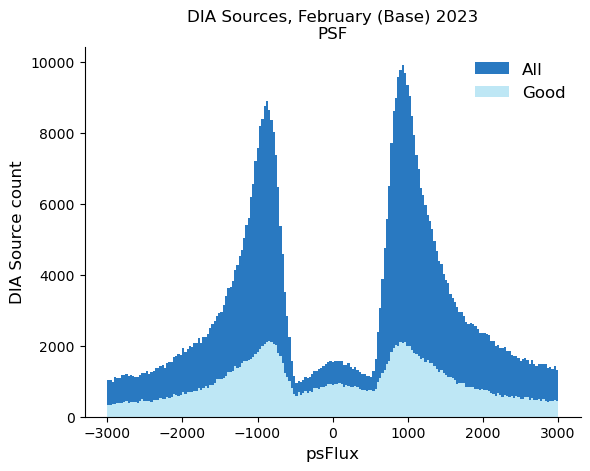

In [20]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}\nPSF')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}\nPSF')

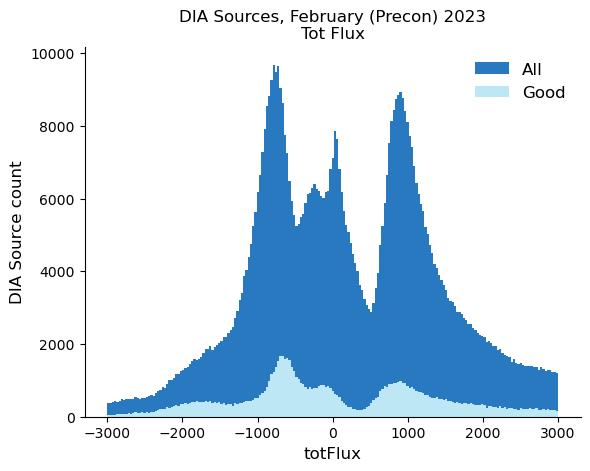

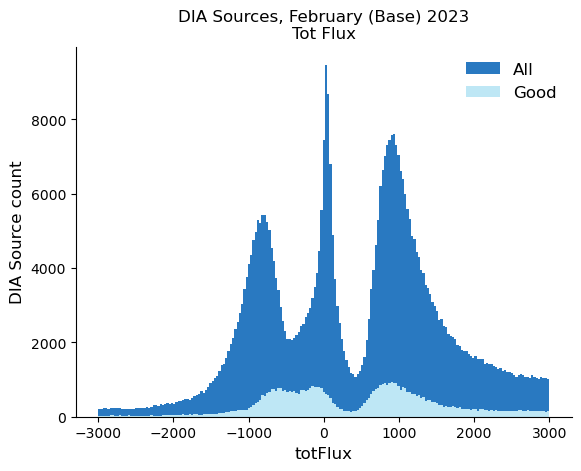

In [21]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}\nTot Flux')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}\nTot Flux')

In [22]:
def spatial_flag_plot(df, df2, flagName1, flagName2=None, operator=None, plotFlagged=True, 
                      plotUnFlagged=True, title='', title2=''):
    if flagName2 and operator:
        if operator == 'or':
            flagFilter = ((df[flagName1]) | (df[flagName2]))
            labelTrue = flagName1 + ' \nor ' + flagName2
            labelFalse = 'Neither ' + flagName1 + ' \nnor ' + flagName2
            
            flagFilter2 = ((df2[flagName1]) | (df2[flagName2]))
            labelTrue2 = flagName1 + ' \nor ' + flagName2
            labelFalse2 = 'Neither ' + flagName1 + ' \nnor ' + flagName2
        elif operator == 'and':
            flagFilter = ((df[flagName1]) & (df[flagName2]))
            labelTrue = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse = 'Not ' + flagName1 + ' \nand ' + flagName2
            
            flagFilter2 = ((df2[flagName1]) & (df2[flagName2]))
            labelTrue2 = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse2 = 'Not ' + flagName1 + ' \nand ' + flagName2
        else:
            raise ValueError('Operator must be \'and\' or \n \'or\'')
    elif flagName2 and not operator:
        raise ValueError('Operator must be set if a second flag is given')
    else:  # just considering one flag
        flagFilter = (df[flagName1])
        labelTrue = flagName1
        labelFalse = 'No ' + flagName1
        
        flagFilter2 = (df2[flagName1])
        labelTrue2 = flagName1
        labelFalse2 = 'No ' + flagName1
    flagFilterInverse = ~flagFilter
    flagFilterInverse2 = ~flagFilter2
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    if plotFlagged:
        scatterFlagged = ax.scatter(df.loc[flagFilter, 'ra'], df.loc[flagFilter, 'decl'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
        scatterFlagged = ax2.scatter(df2.loc[flagFilter2, 'ra'], df2.loc[flagFilter2, 'decl'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
    if plotUnFlagged:
        scatterUnflagged = ax.scatter(df.loc[flagFilterInverse, 'ra'], df.loc[flagFilterInverse, 'decl'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
        scatterUnflagged = ax2.scatter(df2.loc[flagFilterInverse2, 'ra'], df2.loc[flagFilterInverse2, 'decl'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
        
    print(f'--{month} {year}--')
    print('Flagged sources: {0}'.format(len(df.loc[flagFilter, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df.loc[flagFilterInverse, 'ra'])))
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title)
    
    print(f'--{month_old} {year_old}--')
    print('Flagged sources: {0}'.format(len(df2.loc[flagFilter2, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df2.loc[flagFilterInverse2, 'ra'])))
    ax2.set_xlabel('RA (deg)')
    ax2.set_ylabel('Dec (deg)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title(title2)
    
    xlim = (150.8, 149.8)
    ylim = (2.4, 3.1)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    plt.setp(ax2, xlim=xlim, ylim=ylim)
    plt.suptitle(f'Flagged vs Unflagged Sources ({fakeStatus})')

--February (Precon) 2023--
Flagged sources: 771097
Unflagged sources: 397493
--February (Base) 2023--
Flagged sources: 553126
Unflagged sources: 357925


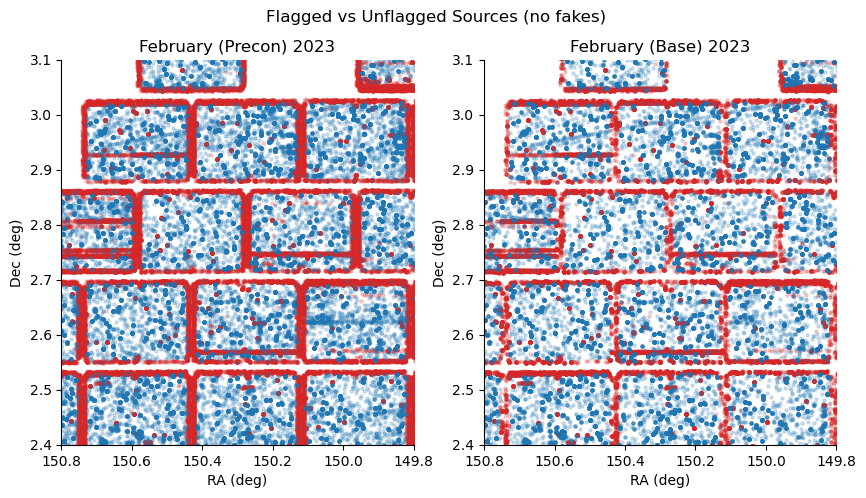

In [23]:
spatial_flag_plot(srcTableFlags, srcTableFlags_old, 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_suspect', operator='or',
                  title=f'{month} {year}', title2=f'{month_old} {year_old}')

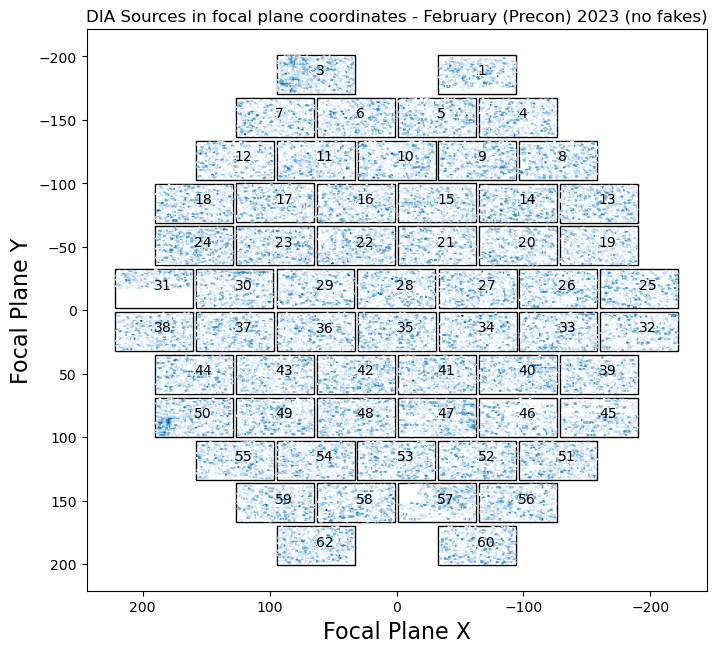

In [24]:
plac.plotDiaSourcesInFocalPlane(repo, goodSrc, title=f'- {month} {year} ({fakeStatus})', instrument='DECam',
                               collections=collections)

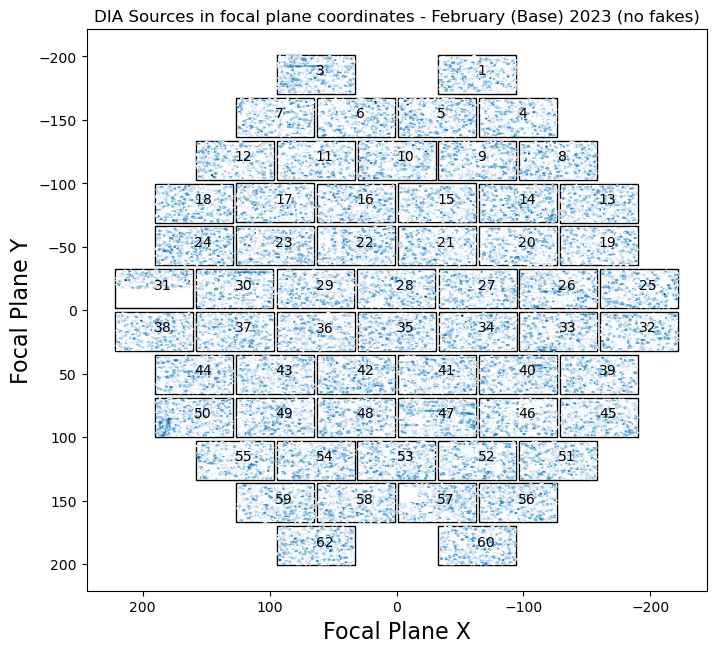

In [25]:
plac.plotDiaSourcesInFocalPlane(repo, goodSrc_old, title=f'- {month_old} {year_old} ({fakeStatus})', instrument='DECam',
                               collections=collections_old)

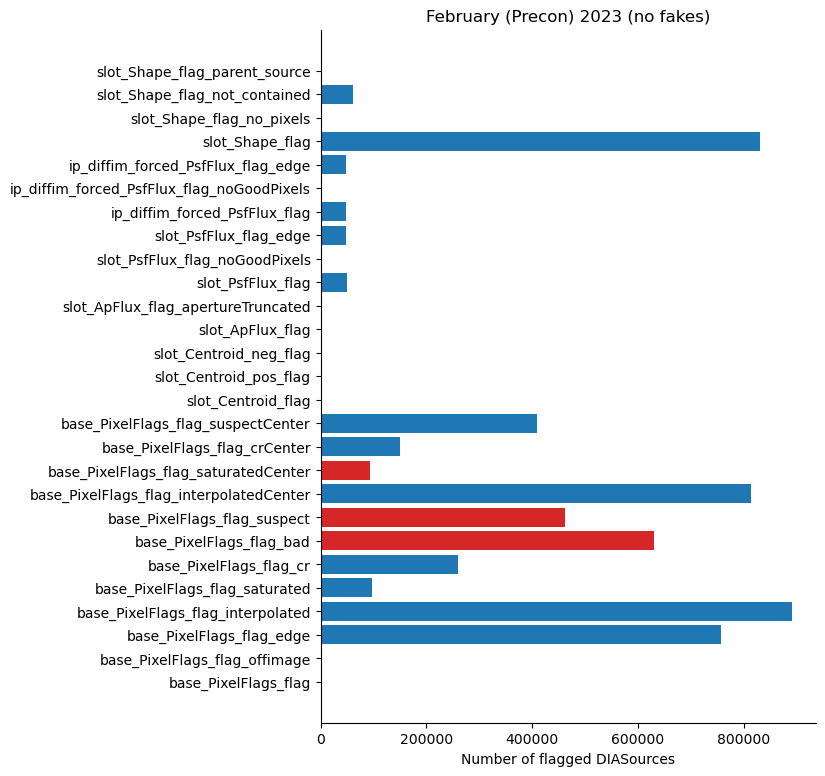

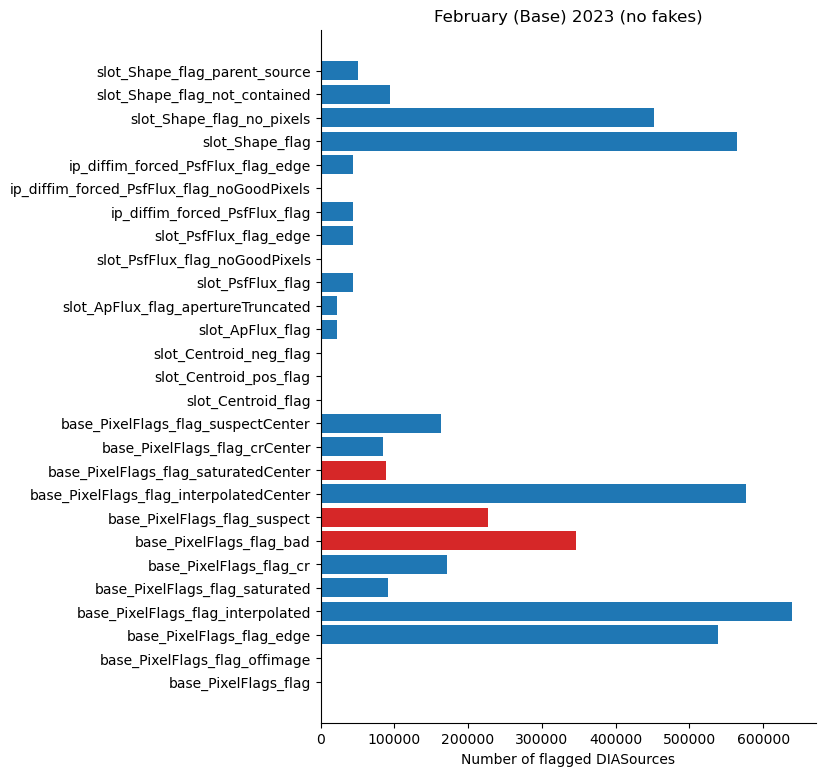

In [26]:
plac.plotFlagHist(srcTable, title=f'{month} {year} ({fakeStatus})')
plac.plotFlagHist(srcTable_old, title=f'{month_old} {year_old} ({fakeStatus})')

## 4. <a id="section_4">SNR distributions</a>
No significant changes in SNR distributions.

Text(0.5, 0, 'SNR of DIA Sources')

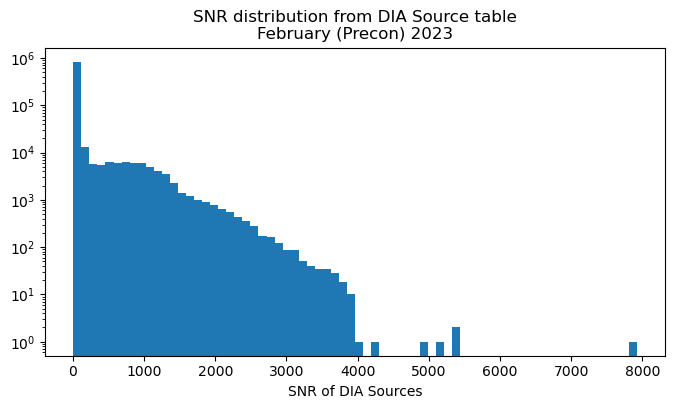

In [27]:
plt.figure(figsize=(8,4))
plt.yscale('log')
snrHist = plt.hist(srcTable_old.snr, bins=70)
plt.title(f'SNR distribution from DIA Source table\n{month} {year}')
plt.xlabel('SNR of DIA Sources')

Text(0.5, 0, 'SNR of DIA Sources')

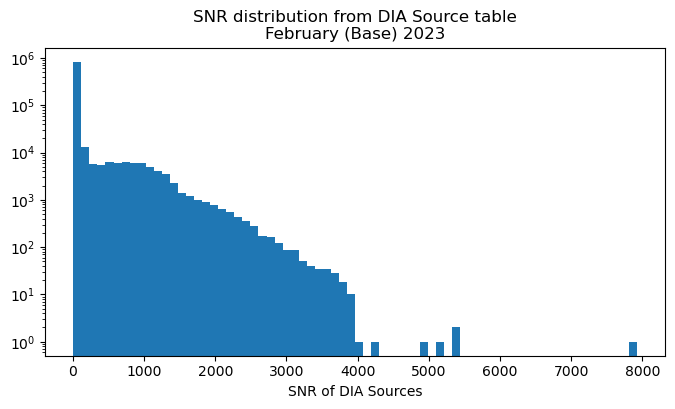

In [28]:
plt.figure(figsize=(8,4))
plt.yscale('log')
snrHist = plt.hist(srcTable_old.snr, bins=70)
plt.title(f'SNR distribution from DIA Source table\n{month_old} {year_old}')
plt.xlabel('SNR of DIA Sources')

In [29]:
# Pre-snr column:
srcTable['psFluxSNR'] = srcTable.psFlux / srcTable.psFluxErr
srcTable['totFluxSNR'] = srcTable.totFlux / srcTable.totFluxErr

srcTable_old['psFluxSNR'] = srcTable_old.psFlux / srcTable_old.psFluxErr
srcTable_old['totFluxSNR'] = srcTable_old.totFlux / srcTable_old.totFluxErr

Text(0.5, 0, 'psFlux/psFluxErr')

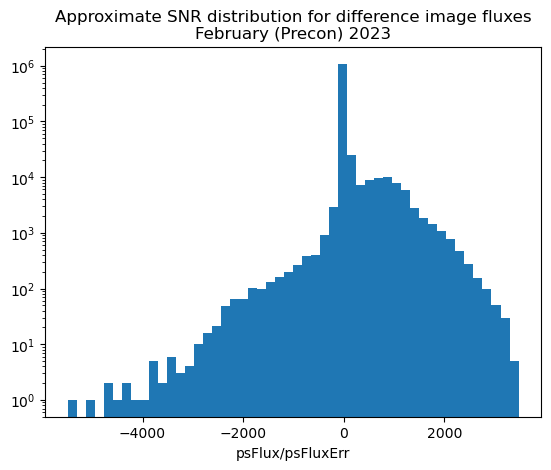

In [30]:
plt.figure()
plt.yscale('log')
psFluxHist = plt.hist(srcTable.psFluxSNR, bins=50)
plt.title(f'Approximate SNR distribution for difference image fluxes\n{month} {year}')
plt.xlabel('psFlux/psFluxErr')

Text(0.5, 0, 'psFlux/psFluxErr')

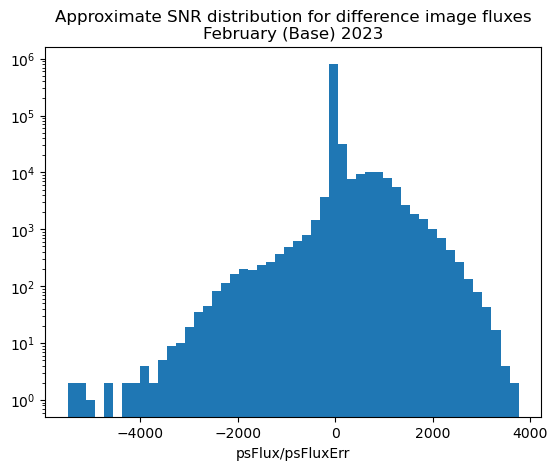

In [31]:
plt.figure()
plt.yscale('log')
psFluxHist = plt.hist(srcTable_old.psFluxSNR, bins=50)
plt.title(f'Approximate SNR distribution for difference image fluxes\n{month_old} {year_old}')
plt.xlabel('psFlux/psFluxErr')

Text(0.5, 0, 'totFlux/totFluxErr')

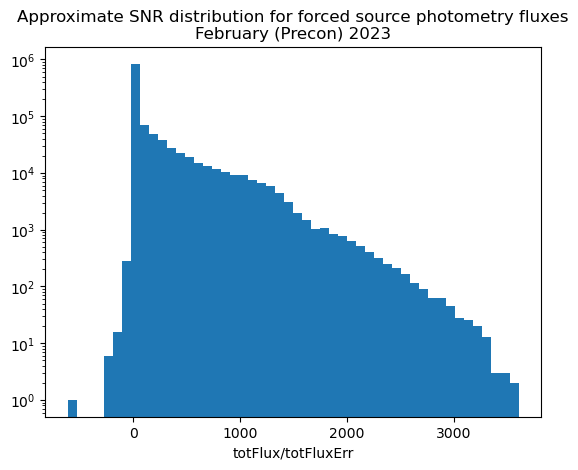

In [32]:
plt.figure()
plt.yscale('log')
totFluxHist = plt.hist(srcTable.totFluxSNR, bins=50)
plt.title(f'Approximate SNR distribution for forced source photometry fluxes\n{month} {year}')
plt.xlabel('totFlux/totFluxErr')

Text(0.5, 0, 'totFlux/totFluxErr')

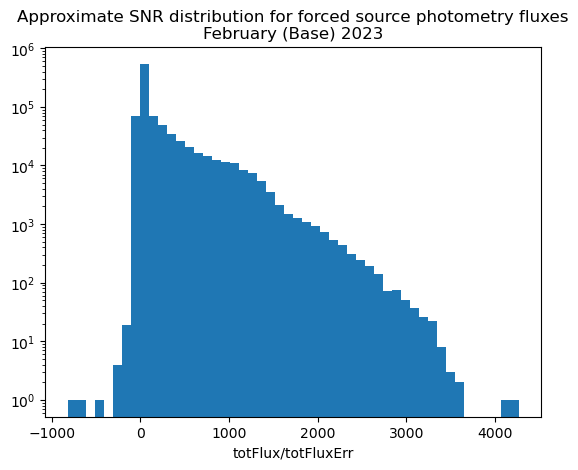

In [33]:
plt.figure()
plt.yscale('log')
totFluxHist = plt.hist(srcTable_old.totFluxSNR, bins=50)
plt.title(f'Approximate SNR distribution for forced source photometry fluxes\n{month_old} {year_old}')
plt.xlabel('totFlux/totFluxErr')